In [2]:
import numpy as np
import ZebraLib as zb
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## Usando robusnewton pra acertar a carga máxima de decolagem

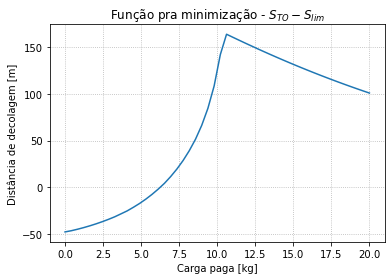

In [47]:
#Função pra ser minimizada - Decolagem
def resid(x, args):
    x_lim = args
    Zb = zb.Airplane(Load=x)
    H = Zb.takeOff_Distance_EDO(rho=zb.alt2rho(1212))
    Sa = Zb.hdist_Obstacle(rho=zb.alt2rho(1212))
    return (H+Sa)-x_lim

x = np.linspace(0, 20)

fig, ax = plt.subplots()
ax.set( title=r'Função pra minimização - $S_{TO} - S_{lim}$', 
        xlabel='Carga paga [kg]', 
        ylabel='Distância de decolagem [m]')

ax.plot(x, np.vectorize(resid)(x, 57))
ax.grid(ls='dotted')

In [50]:
#Valor máximo de carga paga para a condição
zb.robustNewton(resid, (5.), args=(57), xtol=1e-1, nitermax=200)

(6.251241672639157, 4, -0.07952638899662645)

## Resolvendo a EDO de decolagem - com solve_ivp()

In [3]:
from scipy.integrate import odeint
from scipy.integrate import quad, solve_ivp

Zb = zb.Airplane(Load=5.5)

rho=1.225
Ground_Effect=False
pol_grau=6

#PRECISA INVERTER OLD V, T --> NEW T, V
def ED0_takeOff(t, v): 
    T = Zb.trac_Available(v, rho)
    D = Zb.drag_Force(v, Zb.CLLO, rho, Ground_Effect)  # Testar CLmax e CLn or CLLO
    R = Zb.mi * (Zb.W - Zb.lift_Force(v, Zb.CLLO, rho))
    #D = Zb.drag_Force(v, Zb.CLLO, rho, Ground_Effect)  # Testar CLmax e CLn or CLLO
    #R = Zb.mi * (Zb.W - Zb.lift_Force(v, Zb.CLLO, rho))
    dvdt = (T - D - R) / (Zb.M)
    return dvdt

tempo_limite = 20
tempo = np.linspace(1e-1, tempo_limite, 20)

# Solução EDO V(t) e aproximando para polinômio
#V = odeint(ED0_takeOff, 0., tempo)

t_span = np.array([0., 20.])
Y0 = np.array([0.])

V = solve_ivp(ED0_takeOff, t_span, Y0, t_eval=tempo)
pol = zb.fit(tempo, V.y[0], pol_grau)  # Polinomio de grau 6

V.message

'The solver successfully reached the end of the integration interval.'

In [5]:
Vlo_index = zb.get_index_of_nearest_element(
    V, float(Zb.veloc_Req(Zb.CLmax, rho) * 1.2)
)

# Espaço total de pista
espaço_total = quad(pol, min(tempo), tempo[Vlo_index])[0]
espaço_total

TypeError: unsupported operand type(s) for -: 'str' and 'float'

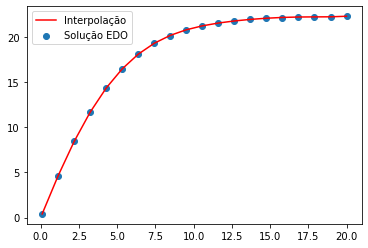

In [91]:
plt.scatter(V.t, V.y[0], label='Solução EDO')
plt.plot(V.t, pol(V.t),c='red', label='Interpolação')
plt.legend()

In [ ]:
f